### 1. Просмотр данных

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.neighbors import KDTree
from collections import Counter
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, auc, precision_recall_curve

In [2]:
df = pd.read_csv('data/training.csv', index_col=0, parse_dates=['PurchDate'])
df.head()

,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,...,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
RefId,,,,,,,,,,,,,,,,,,,,,
1,0,2009-12-07,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I,RED,...,11597.0,12409.0,NaN,NaN,21973,33619,FL,7100.0,0,1113
2,0,2009-12-07,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,WHITE,...,11374.0,12791.0,NaN,NaN,19638,33619,FL,7600.0,0,1053
3,0,2009-12-07,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,MAROON,...,7146.0,8702.0,NaN,NaN,19638,33619,FL,4900.0,0,1389
4,0,2009-12-07,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN,SILVER,...,4375.0,5518.0,NaN,NaN,19638,33619,FL,4100.0,0,630
5,0,2009-12-07,ADESA,2005,4,FORD,FOCUS,ZX3,2D COUPE ZX3,SILVER,...,6739.0,7911.0,NaN,NaN,19638,33619,FL,4000.0,0,1020


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72983 entries, 1 to 73014
Data columns (total 33 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   IsBadBuy                           72983 non-null  int64         
 1   PurchDate                          72983 non-null  datetime64[ns]
 2   Auction                            72983 non-null  object        
 3   VehYear                            72983 non-null  int64         
 4   VehicleAge                         72983 non-null  int64         
 5   Make                               72983 non-null  object        
 6   Model                              72983 non-null  object        
 7   Trim                               70623 non-null  object        
 8   SubModel                           72975 non-null  object        
 9   Color                              72975 non-null  object        
 10  Transmission                       7297

In [4]:
X = df.drop('IsBadBuy', axis=1)
y = df['IsBadBuy']

In [5]:
numeric_features = X.select_dtypes(include=['number'])
categorical_features = X.select_dtypes(include=['object'])

print(f'Count numeric: {len(numeric_features.columns.tolist())}')
print('Numeric features:', numeric_features.columns.tolist())
print(f'Count category: {len(categorical_features.columns.tolist())}')
print('Categorical features:', categorical_features.columns.tolist())

Count numeric: 17
Numeric features: ['VehYear', 'VehicleAge', 'WheelTypeID', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 'BYRNO', 'VNZIP1', 'VehBCost', 'IsOnlineSale', 'WarrantyCost']
Count category: 14
Categorical features: ['Auction', 'Make', 'Model', 'Trim', 'SubModel', 'Color', 'Transmission', 'WheelType', 'Nationality', 'Size', 'TopThreeAmericanName', 'PRIMEUNIT', 'AUCGUART', 'VNST']


### 2. Разделение данных (train.PurchDate < valid.PurchDate < test.PurchDate)

In [6]:
def split_df(df_split):
    sort_df = df_split.sort_values(by='PurchDate', ascending=True)

    train_end = int(len(sort_df) * 0.33)
    valid_end = int(len(sort_df) * 0.66)

    X = sort_df.drop('IsBadBuy', axis=1)
    y = sort_df['IsBadBuy']

    X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
    X_valid, y_valid = X.iloc[train_end:valid_end], y.iloc[train_end:valid_end]
    X_test, y_test = X.iloc[valid_end:], y.iloc[valid_end:]

    print(sort_df.shape)

    return X_train, X_valid, X_test, y_train, y_valid, y_test


X_train, X_valid, X_test, y_train, y_valid, y_test = split_df(df)

print(X_train.iloc[:3, :3], y_train.iloc[:3], X_valid.iloc[:3, :3], y_valid.iloc[:3], X_test.iloc[:3, :3],
      y_test.iloc[:3], sep='\n\n')

(72983, 33)
       PurchDate  Auction  VehYear
RefId                             
32389 2009-01-05  MANHEIM     2007
32406 2009-01-05  MANHEIM     2005
32407 2009-01-05  MANHEIM     2004

RefId
32389    0
32406    0
32407    0
Name: IsBadBuy, dtype: int64

       PurchDate  Auction  VehYear
RefId                             
44690 2009-09-11    OTHER     2007
44697 2009-09-11    OTHER     2006
5567  2009-09-11  MANHEIM     2004

RefId
44690    0
44697    0
5567     0
Name: IsBadBuy, dtype: int64

       PurchDate  Auction  VehYear
RefId                             
37502 2010-05-11  MANHEIM     2004
37501 2010-05-11  MANHEIM     2006
63599 2010-05-11  MANHEIM     2004

RefId
37502    0
37501    0
63599    0
Name: IsBadBuy, dtype: int64


In [7]:
def check_split_for_date(X_train, X_valid, X_test):
    print('Train:')
    print(X_train['PurchDate'].min())
    print(X_train['PurchDate'].max())

    print('Valid:')
    print(X_valid['PurchDate'].min())
    print(X_valid['PurchDate'].max())

    print('Test:')
    print(X_test['PurchDate'].min())
    print(X_test['PurchDate'].max())


check_split_for_date(X_train, X_valid, X_test)

Train:
2009-01-05 00:00:00
2009-09-11 00:00:00
Valid:
2009-09-11 00:00:00
2010-05-11 00:00:00
Test:
2010-05-11 00:00:00
2010-12-30 00:00:00


### 3. Предварительная обработка

In [8]:
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

ohe = OneHotEncoder(categories='auto', handle_unknown='ignore')

X_train_test_ohe = ohe.fit_transform(X_train[categorical_features])
X_valid_test_ohe = ohe.transform(X_valid[categorical_features])
X_test_test_ohe = ohe.transform(X_test[categorical_features])

print(X_train_test_ohe.shape)

(24084, 1695)


In [9]:
unique_features = X_train[categorical_features].nunique().sum()
unique_features_is_null = (X_train[categorical_features].isnull().sum() > 0).sum()
print(f'Unique features -> category columns: {unique_features + unique_features_is_null}')

Unique features -> category columns: 1695


In [10]:
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

mms = MinMaxScaler()

X_train_test_mms = mms.fit_transform(X_train[numerical_features])
X_valid_test_mms = mms.transform(X_valid[numerical_features])
X_test_test_mms = mms.transform(X_test[numerical_features])

print(X_train_test_mms.shape)

(24084, 17)


In [11]:
print(f'Numeric columns: {len(X_train[numerical_features].columns)}')

Numeric columns: 17


In [12]:
from sklearn.impute import SimpleImputer, KNNImputer

categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# ColumnTransformer - Совмещенный подход :)

# 1. Заполняем пропуски
preprocessor_fill = ColumnTransformer(
    transformers=[
        ('fill_null_category', SimpleImputer(strategy='constant', fill_value='missing'), categorical_features),
        ('fill_null_numeric', KNNImputer(n_neighbors=2, weights="uniform"), numerical_features),
    ]
)

X_train_filled = preprocessor_fill.fit_transform(X_train)
X_valid_filled = preprocessor_fill.transform(X_valid)
X_test_filled = preprocessor_fill.transform(X_test)

# 2. Кодируем категории и нормализуем числа
preprocessor_encoder = ColumnTransformer(
    transformers=[
        ('category', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
        # Применяем OneHotEncoder к категориальным столбцам
        ('numeric', MinMaxScaler(), numerical_features)  # Применяем StandardScaler к числовым столбцам
    ]
)

X_train_filled = pd.DataFrame(X_train_filled, columns=categorical_features + numerical_features)
X_valid_filled = pd.DataFrame(X_valid_filled, columns=categorical_features + numerical_features)
X_test_filled = pd.DataFrame(X_test_filled, columns=categorical_features + numerical_features)

X_train_transform = preprocessor_encoder.fit_transform(X_train_filled)
X_valid_transform = preprocessor_encoder.transform(X_valid_filled)
X_test_transform = preprocessor_encoder.transform(X_test_filled)

print(X_train_transform.shape)

(24084, 1712)


In [13]:
print(X_train_transform)

[[0.         1.         0.         ... 0.14887393 0.         0.13175099]
 [0.         1.         0.         ... 0.1354579  0.         0.06807845]
 [0.         1.         0.         ... 0.09345034 0.         0.09849346]
 ...
 [0.         0.         1.         ... 0.08795197 0.         0.08399659]
 [0.         0.         1.         ... 0.2419064  0.         0.07404775]
 [0.         0.         1.         ... 0.1253409  0.         0.28894258]]


In [14]:
# print(pd.DataFrame(X_train_transform).isnull().sum().sum())

### 4. Обучение моделей

| Алгоритм                     | Логистическая регрессия (Logistic Regression) | Гауссов Наивный Байес (Gaussian Naive Bayes) | K-Nearest Neighbors (KNN) |
|------------------------------|---------------------------------------------|---------------------------------------------|---------------------------|
| **Описание**                  | Линейная модель для классификации, которая предсказывает вероятность принадлежности к классам. | Статистический метод классификации, который использует теорему Байеса и предположение о нормальном распределении признаков. | Нелинейный метод, который классифицирует объекты на основе сходства с ближайшими соседями в обучающей выборке. |
| **Тип модели**                | Линейная                                   | Статистическая                             | Нелинейная                |
| **Метод обучения**            | Оптимизация логарифмической функции потерь. | Оценка вероятностей на основе распределения признаков. | Нахождение ближайших соседей и классификация на основе голосования. |
| **Особенности**               | Требует линейных зависимостей между признаками и целевой переменной. | Предполагает независимость признаков и нормальное распределение. | Зависит от расстояний между объектами, чувствителен к масштабу данных. |
| **Преимущества**              | Быстрая обучаемость, хороша для линейных данных, интерпретируемая модель. | Быстрое обучение, не требует сложных предположений о данных, работает хорошо с малыми данными. | Работает без предположений о линейности или распределении данных, интуитивно понятен. |
| **Недостатки**                | Плохо работает с нелинейными зависимостями, чувствительна к выбросам. | Чувствителен к выбросам, эффективность снижается при больших данных. | Очень медленный на больших данных, чувствителен к шуму и выбросам. |
| **Когда использовать**        | Когда данные имеют линейные зависимости между признаками и целевой переменной. | Когда признаки независимы и распределены нормально, для малых объемов данных. | Когда нет предположений о данных, например, для сложных нелинейных зависимостей. |
| **Пример использования**      | Бинарная классификация, многоклассовая классификация. | Текстовая классификация, задачи с независимыми признаками. | Рекомендательные системы, задачи с большим количеством данных. |


### Основны метрики классификации:

| **Метрика**             | **Описание**                                                                          | **Плюсы** | **Минусы** |
|-------------------------|---------------------------------------------------------------------------------------|-----------|------------|
| **Accuracy (Точность)** | Доля правильно предсказанных классов ко всем наблюдениям                              | Простая интерпретация | Плохо работает при несбалансированных данных |
| **Precision (Точность, положительный предиктивный показатель)** | Доля истинно положительных объектов среди всех предсказанных положительных            | Полезна, когда важнее избегать ложных срабатываний (FP) | Не учитывает FN |
| **Recall (Полнота, чувствительность)** | Доля правильно предсказанных положительных объектов среди всех реальных положительных | Важна, когда критичны пропуски (FN) | Может давать высокий уровень FP |
| **F1-score** | Среднее гармоническое Precision и Recall                                              | Учитывает и Precision, и Recall | Может быть трудно интерпретируемой |
| **ROC-AUC (Area Under Curve)** | Площадь под ROC-кривой, измеряет способность модели различать классы                  | Устойчив к несбалансированным данным | Может быть сложно интерпретировать |
| **Gini Score** | Коэффициент Джини, связанный с ROC-AUC, измеряющая способность модели различать положительные и отрицательные классы                                              | Используется в кредитном скоринге | Может быть нестабилен на малых данных |
| **Log Loss (Логарифмическая потеря)** | Оценивает качество вероятностных предсказаний                                         | Учитывает степень уверенности модели | Сложна в интерпретации |


### 5. Расчет индекса Gini

In [15]:
def gini_score(y_true, y_score):
    auc = roc_auc_score(y_true, y_score)
    gini = 2 * auc - 1

    print(f'AUC: {auc:.2f}')
    print(f'Gini score: {gini:.2f}')

    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    plt.figure(figsize=(15, 8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'g', label=f'AUC = {auc:.2f} (Gini = {gini:.2f})')
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### Интерпретация графика ROC

1. **ROC-кривая**:
   - **Ось X (FPR)**: Ложный положительный (False Positive Rate) — доля неправильно классифицированных отрицательных объектов как положительные.
   - **Ось Y (TPR или Recall)**: Доля правильно классифицированных положительных объектов.

2. **Линия случайного угадывания**:
   - Диагональ от (0,0) до (1,1), показывающая производительность случайной модели.

3. **AUC (Area Under the Curve)**:
   - **AUC** варьируется от 0 до 1:
     - **0.5**: Модель не лучше случайного угадывания.
     - **1**: Идеальная модель.
   - Чем выше AUC, тем лучше модель.

4. **Gini score**:
   - **Gini = 2 * AUC - 1**.
   - Диапазон от -1 до 1:
     - **0**: Модель не имеет предсказательной силы.
     - **1**: Идеальная модель.
     - **Gini < 0**: Модель хуже случайного угадывания.

              precision    recall  f1-score   support

           0       0.89      0.98      0.93     20926
           1       0.62      0.24      0.34      3158

    accuracy                           0.88     24084
   macro avg       0.76      0.61      0.64     24084
weighted avg       0.86      0.88      0.86     24084

[0.02836775 0.03484574 0.09158927 ... 0.17206485 0.08754335 0.23693439]
AUC: 0.72
Gini score: 0.45


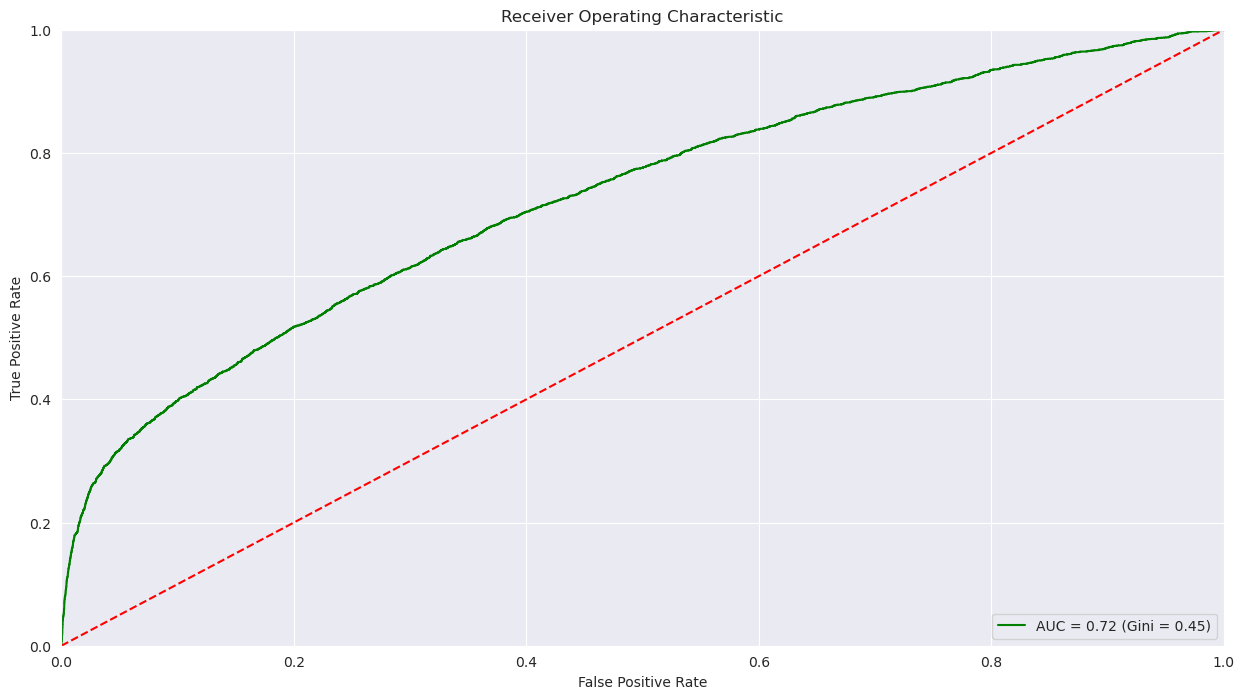

In [16]:
lg = LogisticRegression(random_state=21, n_jobs=-1, max_iter=500)
lg.fit(X_train_transform, y_train)
y_pred = lg.predict(X_valid_transform)
y_pred_proba = lg.predict_proba(X_valid_transform)[:, 1]
print(classification_report(y_valid, y_pred))
print(y_pred_proba)
gini_score(y_valid, y_pred_proba)

              precision    recall  f1-score   support

           0       0.88      0.46      0.61     20926
           1       0.14      0.59      0.23      3158

    accuracy                           0.48     24084
   macro avg       0.51      0.53      0.42     24084
weighted avg       0.79      0.48      0.56     24084

[1. 1. 1. ... 1. 0. 1.]
AUC: 0.53
Gini score: 0.06


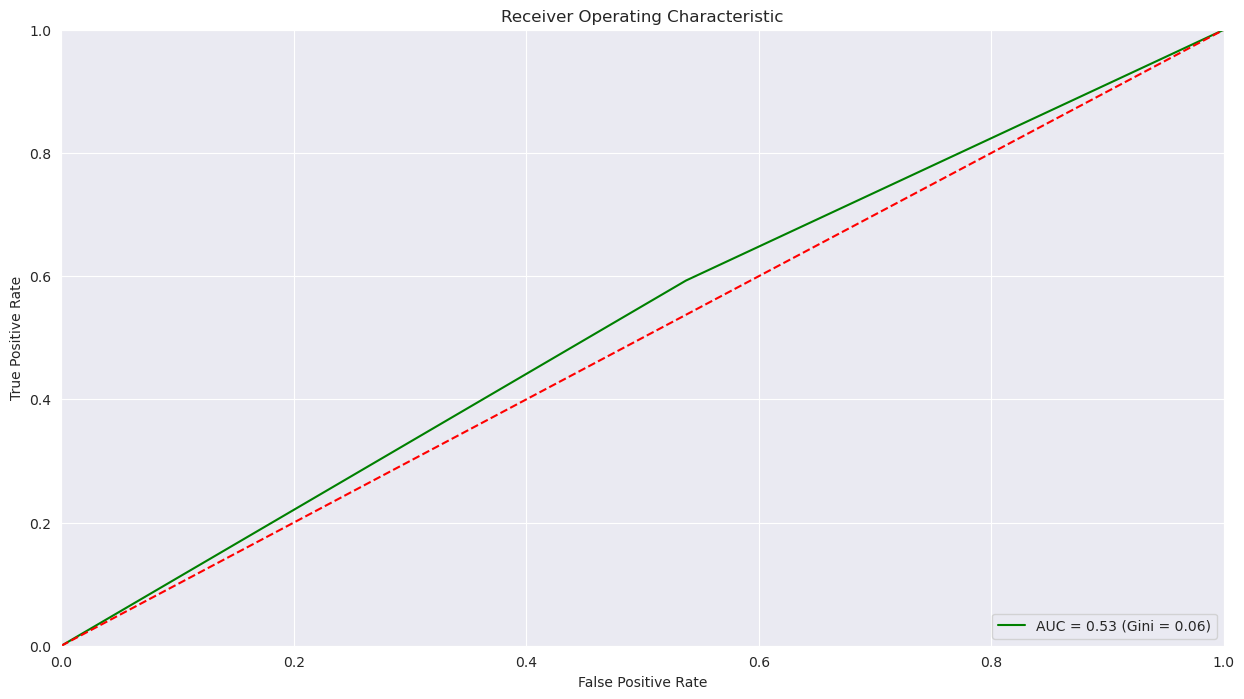

In [17]:
gnb = GaussianNB()
gnb.fit(X_train_transform, y_train)
y_pred = gnb.predict(X_valid_transform)
y_pred_proba = gnb.predict_proba(X_valid_transform)[:, 1]
print(classification_report(y_valid, y_pred))
print(y_pred_proba)
gini_score(y_valid, y_pred_proba)

              precision    recall  f1-score   support

           0       0.88      0.99      0.93     20926
           1       0.52      0.07      0.12      3158

    accuracy                           0.87     24084
   macro avg       0.70      0.53      0.53     24084
weighted avg       0.83      0.87      0.82     24084

[0.2 0.  0.2 ... 0.4 0.2 0.2]
AUC: 0.62
Gini score: 0.24


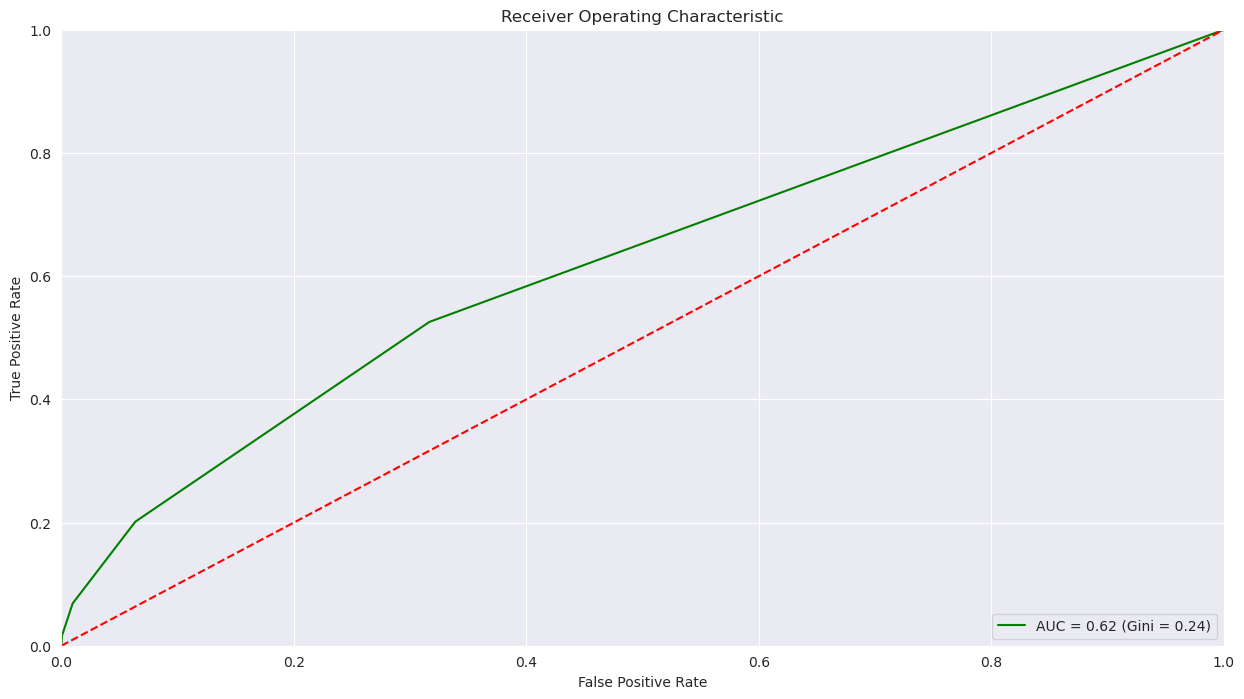

In [18]:
knn = KNeighborsClassifier()
knn.fit(X_train_transform, y_train)
y_pred = knn.predict(X_valid_transform)
y_pred_proba = knn.predict_proba(X_valid_transform)[:, 1]
print(classification_report(y_valid, y_pred))
print(y_pred_proba)
gini_score(y_valid, y_pred_proba)

### 6. Реализация классификаторов

In [19]:
class MyLogisticRegression:
    def __init__(self, rate=0.01, epochs=100000):
        self.rate = rate
        self.epochs = epochs
        self.weights = None  # Веса модели
        self.bias = None  # Смещение (bias)

    def sigmoid(self, z):
        # Сигмоидная функция
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        # Преобразуем DataFrame и Series в NumPy (если они не в этом формате)
        X = X.to_numpy() if isinstance(X, pd.DataFrame) else X
        y = y.to_numpy() if isinstance(y, pd.Series) else y

        # Инициализируем параметры
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)  # Веса модели (размерность = числу признаков)
        self.bias = 0  # Смещение

        # Стохастический градиентный спуск (SGD)
        for epoch in range(self.epochs):
            idx = np.random.randint(n_samples)  # Выбираем случайный образец
            xi, yi = X[idx], y[idx]  # Признаки и целевая переменная

            # Вычисляем предсказание модели
            linear_model = np.dot(xi, self.weights) + self.bias  # Линейная комбинация входов
            prediction = self.sigmoid(linear_model)  # Вероятность принадлежности к классу 1

            # Градиенты функции потерь (логистическая регрессия с бинарной кросс-энтропией)
            dw = (prediction - yi) * xi  # Градиент по весам
            db = (prediction - yi)  # Градиент по bias

            # Обновление параметров
            self.weights -= self.rate * dw
            self.bias -= self.rate * db

    def predict_proba(self, X):
        linear_model = np.dot(X, self.weights) + self.bias  # Линейное преобразование
        p = self.sigmoid(linear_model)  # Вероятность класса 1
        return np.column_stack([1 - p, p])  # Возвращаем вероятности для классов 0 и 1

    def predict(self, X):
        return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)  # Если p >= 0.5 → класс 1, иначе 0


              precision    recall  f1-score   support

           0       0.89      0.98      0.94     20926
           1       0.65      0.22      0.32      3158

    accuracy                           0.88     24084
   macro avg       0.77      0.60      0.63     24084
weighted avg       0.86      0.88      0.85     24084

[0.02700521 0.0402281  0.06177551 ... 0.11199981 0.06534394 0.04691832]
[0 0 0 ... 0 0 0]
AUC: 0.73
Gini score: 0.47


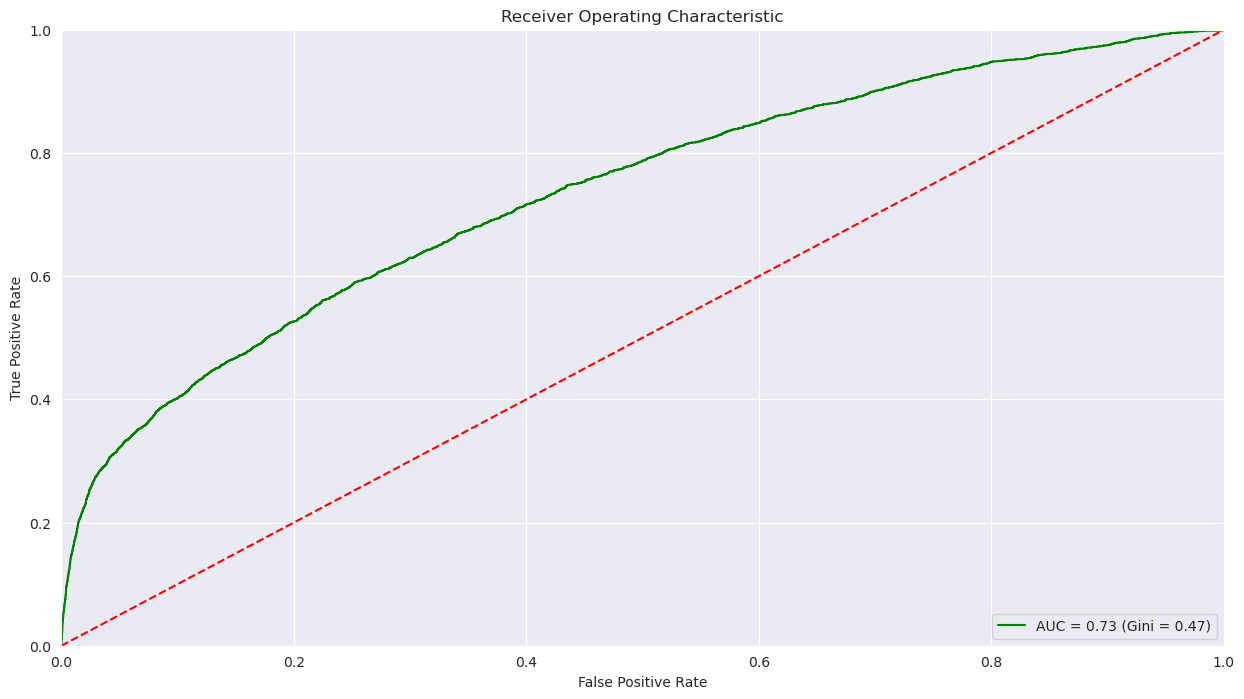

In [20]:
mlr = MyLogisticRegression()
mlr.fit(X_train_transform, y_train)
y_pred = mlr.predict(X_valid_transform)
y_pred_proba = mlr.predict_proba(X_valid_transform)[:, 1]
print(classification_report(y_valid, y_pred))
print(y_pred_proba)
print(y_pred)
gini_score(y_valid, y_pred_proba)

In [21]:
class MyGaussianNB:
    def __init__(self):
        self.class_probs = {}  # Априорные вероятности классов
        self.class_means = {}  # Средние значения признаков для каждого класса
        self.class_std = {}  # Стандартные отклонения признаков для каждого класса
        self.classes = None  # Уникальные классы в обучающей выборке

    def fit(self, X, y):
        self.classes = np.unique(y)  # Определяем все классы в обучающей выборке
        n_samples, n_features = X.shape

        for cls in self.classes:
            X_class = X[y == cls]  # Отбираем объекты данного класса
            self.class_probs[cls] = X_class.shape[0] / n_samples  # Вероятность класса
            self.class_means[cls] = X_class.mean(axis=0)  # Средние значения признаков
            self.class_std[cls] = X_class.std(axis=0)  # Стандартные отклонения

    def _gaussian_pdf(self, X, mean, std):
        std = np.where(std < 1e-6, 1e-6, std)  # Ограничение снизу для std (избегаем деления на 0)
        std = np.where(std > 1e6, 1e6, std)  # Ограничение сверху (избегаем слишком больших значений)

        # Формула плотности нормального распределения
        return (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((X - mean) / std) ** 2)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def predict_proba(self, X):
        log_probs = []

        for cls in self.classes:
            # Логарифм априорной вероятности + сумма логарифмов плотности вероятности для всех признаков
            log_prob = np.log(self.class_probs[cls]) + np.sum(
                np.log(self._gaussian_pdf(X, mean=self.class_means[cls], std=self.class_std[cls])), axis=1
            )
            log_probs.append(log_prob)

        log_probs = np.stack(log_probs, axis=1)  # Объединяем вероятности всех классов
        probs = self.sigmoid(log_probs)  # Преобразуем в вероятность

        return probs

    def predict(self, X):
        return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)  # Класс 1, если вероятность >= 0.5, иначе 0

/tmp/ipykernel_5178/1465500963.py:34: RuntimeWarning: divide by zero encountered in log
  np.log(self._gaussian_pdf(X, mean=self.class_means[cls], std=self.class_std[cls])), axis=1


              precision    recall  f1-score   support

           0       0.88      0.61      0.72     20926
           1       0.14      0.43      0.21      3158

    accuracy                           0.59     24084
   macro avg       0.51      0.52      0.47     24084
weighted avg       0.78      0.59      0.65     24084

AUC: 0.52
Gini score: 0.04


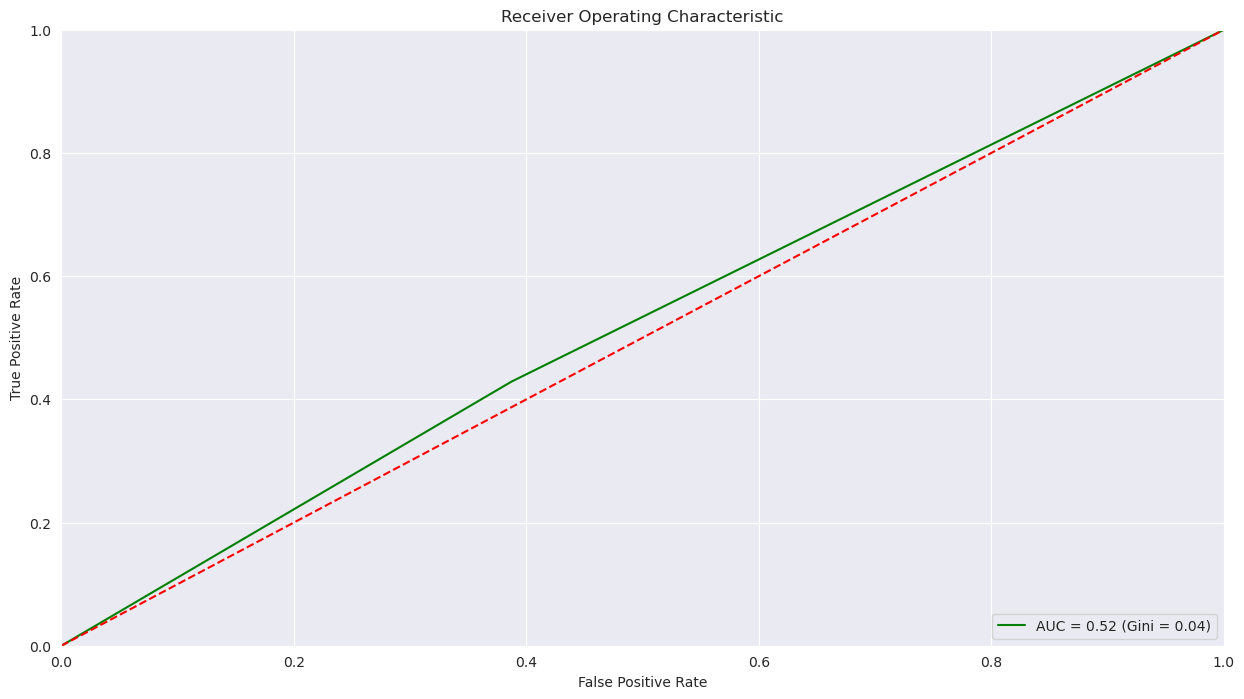

In [22]:
mgnb = MyGaussianNB()
mgnb.fit(X_train_transform, y_train)
y_pred = mgnb.predict(X_valid_transform)
y_pred_proba = mgnb.predict_proba(X_valid_transform)[:, 1]
print(classification_report(y_valid, y_pred))
gini_score(y_valid, y_pred_proba)

In [23]:
class MyKNeighborsClassifier:
    def __init__(self, k=5):
        self.k = k  # Количество ближайших соседей для классификации

    def fit(self, X, y):
        self.X_train = X  # Сохраняем обучающие примеры
        self.y_train = y  # Сохраняем метки классов
        self.tree = KDTree(X, leaf_size=30)  # Строим KD-дерево для быстрого поиска соседей

    def predict(self, X):
        return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)  # Класс 1, если вероятность ≥ 0.5, иначе 0

    def predict_proba(self, X):
        # Находим k ближайших соседей для каждого объекта X
        dist, ind = self.tree.query(X, k=self.k)
        probs = []

        for i in range(X.shape[0]):
            neighbors_classes = self.y_train[ind[i]]  # Метки классов соседей
            counts = Counter(neighbors_classes)  # Подсчет количества классов среди соседей

            # Вычисляем вероятность для каждого класса
            probs_for_instance = [counts[class_] / self.k for class_ in np.unique(self.y_train)]
            probs.append(probs_for_instance)

        return np.array(probs)  # Возвращаем вероятности для каждого объекта

              precision    recall  f1-score   support

           0       0.87      0.99      0.93       348
           1       0.33      0.02      0.04        52

    accuracy                           0.87       400
   macro avg       0.60      0.51      0.48       400
weighted avg       0.80      0.87      0.81       400

AUC: 0.66
Gini score: 0.33


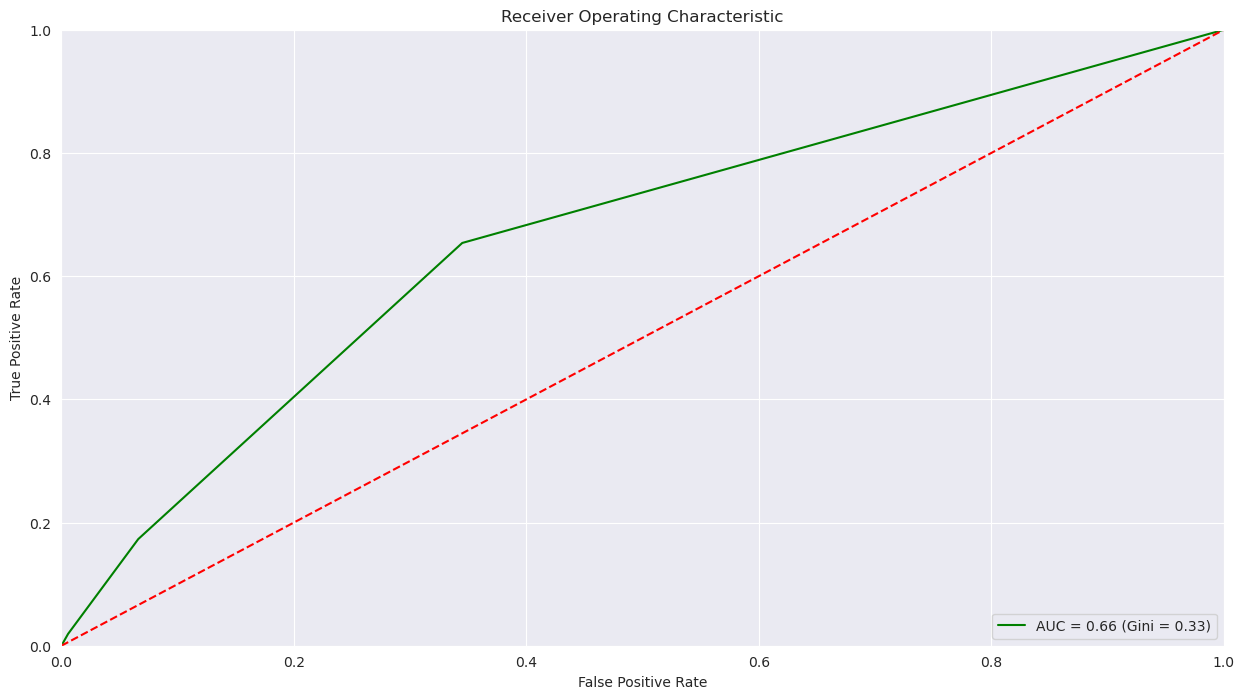

In [24]:
n = 400
mknc = MyKNeighborsClassifier(k=5)
mknc.fit(X_train_transform, np.array(y_train))
y_pred = mknc.predict(X_valid_transform[:n])
y_pred_proba = mknc.predict_proba(X_valid_transform[:n])[:, 1]
print(classification_report(y_valid[:n], y_pred))
gini_score(y_valid[:n], y_pred_proba)

### 7. Добавление нелинейных признаков

In [25]:
def only_gini(y_true, y_score):
    auc = roc_auc_score(y_true, y_score)
    gini = 2 * auc - 1

    print(f'AUC: {auc:.4f}')
    print(f'Gini score: {gini:.4f}')

In [26]:
new_features = pd.DataFrame(df['PurchDate'])
new_features = new_features.sort_values(by=['PurchDate'])
new_features['VehOdo_per_VehicleAge'] = df.apply(
    lambda row: row['VehOdo'] / row['VehicleAge'] if row['VehicleAge'] > 0 else 0, axis=1)
new_features['VehBCost_mean_per_IsOnlineSale'] = df['IsOnlineSale'].map(df.groupby('IsOnlineSale')[('VehBCost')].mean())
new_features['VehBCost_mean_per_Color'] = df['Color'].map(df.groupby('Color')[('VehBCost')].mean())
new_features['VehBCost_mean_per_Color'] = new_features['VehBCost_mean_per_Color'].fillna(
    new_features['VehBCost_mean_per_Color'].mean())
new_features.head(3)

,PurchDate,VehOdo_per_VehicleAge,VehBCost_mean_per_IsOnlineSale,VehBCost_mean_per_Color
RefId,,,,
32389,2009-01-05,39270.5,6721.220289,6718.688887
32406,2009-01-05,9419.0,6721.220289,6609.977605
32407,2009-01-05,14336.0,6721.220289,6609.977605


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72983 entries, 1 to 73014
Data columns (total 33 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   IsBadBuy                           72983 non-null  int64         
 1   PurchDate                          72983 non-null  datetime64[ns]
 2   Auction                            72983 non-null  object        
 3   VehYear                            72983 non-null  int64         
 4   VehicleAge                         72983 non-null  int64         
 5   Make                               72983 non-null  object        
 6   Model                              72983 non-null  object        
 7   Trim                               70623 non-null  object        
 8   SubModel                           72975 non-null  object        
 9   Color                              72975 non-null  object        
 10  Transmission                       7297

In [28]:
train_end = int(len(new_features) * 0.33)
valid_end = int(len(new_features) * 0.66)

print(train_end, valid_end)
train_features, valid_features, test_features = new_features.iloc[:train_end], new_features.iloc[
                                                                               train_end:valid_end], new_features.iloc[
                                                                                                     valid_end:]
check_split_for_date(train_features, valid_features, test_features)
print(new_features.shape)

24084 48168
Train:
2009-01-05 00:00:00
2009-09-11 00:00:00
Valid:
2009-09-11 00:00:00
2010-05-11 00:00:00
Test:
2010-05-11 00:00:00
2010-12-30 00:00:00
(72983, 4)


In [29]:
mms = MinMaxScaler()

numerical_features = new_features.select_dtypes(include='number').columns.to_list()

if type(train_features) == pd.DataFrame:
    train_features = mms.fit_transform(train_features[numerical_features])
    valid_features = mms.transform(valid_features[numerical_features])
    test_features = mms.transform(test_features[numerical_features])

In [30]:
X_train_combined = np.concatenate((train_features, X_train_transform), axis=1)
X_valid_combined = np.concatenate((valid_features, X_valid_transform), axis=1)
X_test_combined = np.concatenate((test_features, X_test_transform), axis=1)

In [31]:
lg = LogisticRegression(random_state=21, n_jobs=-1, max_iter=500)
lg.fit(X_train_transform, y_train)
y_pred = lg.predict(X_valid_transform)
y_pred_proba_old = lg.predict_proba(X_valid_transform)[:, 1]
print(classification_report(y_valid, y_pred))
print(y_pred_proba_old)
only_gini(y_valid, y_pred_proba_old)

              precision    recall  f1-score   support

           0       0.89      0.98      0.93     20926
           1       0.62      0.24      0.34      3158

    accuracy                           0.88     24084
   macro avg       0.76      0.61      0.64     24084
weighted avg       0.86      0.88      0.86     24084

[0.02836775 0.03484574 0.09158927 ... 0.17206485 0.08754335 0.23693439]
AUC: 0.7247
Gini score: 0.4495


In [32]:
lg = LogisticRegression(random_state=21, n_jobs=-1, max_iter=500)
lg.fit(X_train_combined, y_train)
y_pred = lg.predict(X_valid_combined)
y_pred_proba_new = lg.predict_proba(X_valid_combined)[:, 1]
print(classification_report(y_valid, y_pred))
print(y_pred_proba_new)
only_gini(y_valid, y_pred_proba_new)

              precision    recall  f1-score   support

           0       0.89      0.98      0.93     20926
           1       0.63      0.23      0.34      3158

    accuracy                           0.88     24084
   macro avg       0.76      0.61      0.64     24084
weighted avg       0.86      0.88      0.86     24084

[0.02973422 0.03551208 0.09278018 ... 0.17375301 0.08839675 0.23038524]
AUC: 0.7251
Gini score: 0.4501


### 8. Отбор признаков

In [33]:
lg = LogisticRegression(random_state=21, n_jobs=-1, max_iter=500)
lg.fit(X_train_transform, y_train)
features = pd.Series(lg.coef_[0]).abs().sort_values(ascending=False)
print(features)

1641    2.571790
505     1.609445
1709    1.486533
1160    1.466229
1698    1.349383
          ...   
285     0.001826
1048    0.001275
624     0.000797
818     0.000440
1710    0.000000
Length: 1712, dtype: float64


In [34]:
selected = features[features > 0.1]
print(selected.index)

Index([1641,  505, 1709, 1160, 1698,  119,  522,  400, 1169,  403,
       ...
       1161,   32,  332, 1500, 1225,  329,  500,  234, 1510,  596],
      dtype='int64', length=1215)


In [35]:
selected_features = selected.index.tolist()
X_train_selected = X_train_transform[:, selected_features]
X_valid_selected = X_valid_transform[:, selected_features]

In [36]:
lg = LogisticRegression(random_state=21, n_jobs=-1, max_iter=500)
lg.fit(X_train_selected, y_train)
y_pred = lg.predict(X_valid_selected)
y_pred_proba = lg.predict_proba(X_valid_selected)[:, 1]
print(classification_report(y_valid, y_pred))
print(y_pred_proba)
only_gini(y_valid, y_pred_proba)

              precision    recall  f1-score   support

           0       0.89      0.98      0.93     20926
           1       0.62      0.24      0.34      3158

    accuracy                           0.88     24084
   macro avg       0.76      0.61      0.64     24084
weighted avg       0.86      0.88      0.86     24084

[0.0279078  0.0361334  0.09338944 ... 0.1580336  0.0888129  0.25023199]
AUC: 0.7258
Gini score: 0.4516


In [37]:
lg = LogisticRegression(solver='liblinear', penalty='l1', random_state=21, max_iter=500)
lg.fit(X_train_transform, y_train)
y_pred = lg.predict(X_valid_transform)
y_pred_proba = lg.predict_proba(X_valid_transform)[:, 1]
print(classification_report(y_valid, y_pred))
print(y_pred_proba)
only_gini(y_valid, y_pred_proba)

              precision    recall  f1-score   support

           0       0.89      0.98      0.93     20926
           1       0.61      0.22      0.32      3158

    accuracy                           0.88     24084
   macro avg       0.75      0.60      0.63     24084
weighted avg       0.86      0.88      0.85     24084

[0.0277341  0.03572178 0.08850639 ... 0.10434819 0.08290381 0.12439203]
AUC: 0.7275
Gini score: 0.4551


### 9. Метод опорных векторов (SVM)

In [38]:
svm = SVC(random_state=21, probability=True, kernel='rbf', gamma='auto')
svm.fit(X_train_transform, y_train)
y_pred = svm.predict(X_valid_transform)
y_pred_proba = svm.predict_proba(X_valid_transform)[:, 1]
print(classification_report(y_valid, y_pred))
print(y_pred_proba)
gini_score(y_valid, y_pred_proba)

![](data/SVM.png)

![](data/SVM_ROC.png)

### 10. Оптимизация лучшей модели

In [41]:
params = {
    'C': [1, 3, 5],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'max_iter': [100, 500, 1000],
    'random_state': [21],
}

model = LogisticRegression()
grid_search = GridSearchCV(estimator=model, param_grid=params, n_jobs=1, verbose=1, scoring='roc_auc')
grid_search.fit(X_train_transform, y_train)

print(f'Best params: {grid_search.best_params_}')
print(f'Best score (AUC): {grid_search.best_score_}')

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best params: {'C': 1, 'max_iter': 100, 'penalty': 'l1', 'random_state': 21, 'solver': 'liblinear'}
Best score (AUC): 0.7406632852219048


In [64]:
search_results = pd.DataFrame(grid_search.cv_results_)
search_results.sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_max_iter,param_penalty,param_random_state,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.056012,0.319192,0.008483,0.000848,1,100,l1,21,liblinear,"{'C': 1, 'max_iter': 100, 'penalty': 'l1', 'ra...",0.720704,0.710206,0.777133,0.741669,0.753605,0.740663,0.023768,1
2,1.988445,0.396879,0.008332,0.000921,1,500,l1,21,liblinear,"{'C': 1, 'max_iter': 500, 'penalty': 'l1', 'ra...",0.720704,0.710206,0.777133,0.741669,0.753605,0.740663,0.023768,1
4,2.170555,0.582729,0.009849,0.001087,1,1000,l1,21,liblinear,"{'C': 1, 'max_iter': 1000, 'penalty': 'l1', 'r...",0.720704,0.710206,0.777133,0.741669,0.753605,0.740663,0.023768,1
1,0.488128,0.025431,0.009731,0.001044,1,100,l2,21,liblinear,"{'C': 1, 'max_iter': 100, 'penalty': 'l2', 'ra...",0.718193,0.709066,0.767827,0.736818,0.748479,0.736077,0.021033,4
3,0.414629,0.022221,0.007786,0.000153,1,500,l2,21,liblinear,"{'C': 1, 'max_iter': 500, 'penalty': 'l2', 'ra...",0.718193,0.709066,0.767827,0.736818,0.748479,0.736077,0.021033,4


In [56]:
param_penalty = search_results.groupby(['param_penalty']).agg({'mean_test_score': 'mean', 'std_test_score': 'mean'})
param_C = search_results.groupby(['param_C']).agg({'mean_test_score': 'mean', 'std_test_score': 'mean'})
print(param_penalty, param_C, sep='\n\n')

               mean_test_score  std_test_score
param_penalty                                 
l1                    0.729436        0.020071
l2                    0.728830        0.018603

         mean_test_score  std_test_score
param_C                                 
1               0.738370        0.022400
3               0.727515        0.018453
5               0.721514        0.017157


### 11. Gini score 

In [98]:
model = LogisticRegression(**grid_search.best_params_, class_weight='balanced')
print(model.get_params())

{'C': 1, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l1', 'random_state': 21, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [99]:
model.fit(X_train_transform, y_train)

y_pred_train = model.predict(X_train_transform)
y_pred_valid = model.predict(X_valid_transform)
y_pred_test = model.predict(X_test_transform)

y_pred_proba_train = model.predict_proba(X_train_transform)[:, 1]
y_pred_proba_valid = model.predict_proba(X_valid_transform)[:, 1]
y_pred_proba_test = model.predict_proba(X_test_transform)[:, 1]

print('Train: \n', classification_report(y_train, y_pred_train))
print('Valid: \n', classification_report(y_valid, y_pred_valid))
print('Test: \n', classification_report(y_test, y_pred_test))

Train: 
               precision    recall  f1-score   support

           0       0.95      0.77      0.85     21328
           1       0.28      0.70      0.40      2756

    accuracy                           0.76     24084
   macro avg       0.62      0.73      0.63     24084
weighted avg       0.87      0.76      0.80     24084

Valid: 
               precision    recall  f1-score   support

           0       0.92      0.79      0.85     20926
           1       0.28      0.53      0.36      3158

    accuracy                           0.76     24084
   macro avg       0.60      0.66      0.61     24084
weighted avg       0.83      0.76      0.79     24084

Test: 
               precision    recall  f1-score   support

           0       0.92      0.72      0.81     21753
           1       0.23      0.58      0.32      3062

    accuracy                           0.70     24815
   macro avg       0.57      0.65      0.57     24815
weighted avg       0.84      0.70      0.75     

In [100]:
print('Train:')
only_gini(y_train, y_pred_proba_train)
print('Valid:')
only_gini(y_valid, y_pred_proba_valid)
print('Test:')
only_gini(y_test, y_pred_proba_test)

Train:
AUC: 0.8202
Gini score: 0.6404
Valid:
AUC: 0.7200
Gini score: 0.4400
Test:
AUC: 0.7090
Gini score: 0.4180


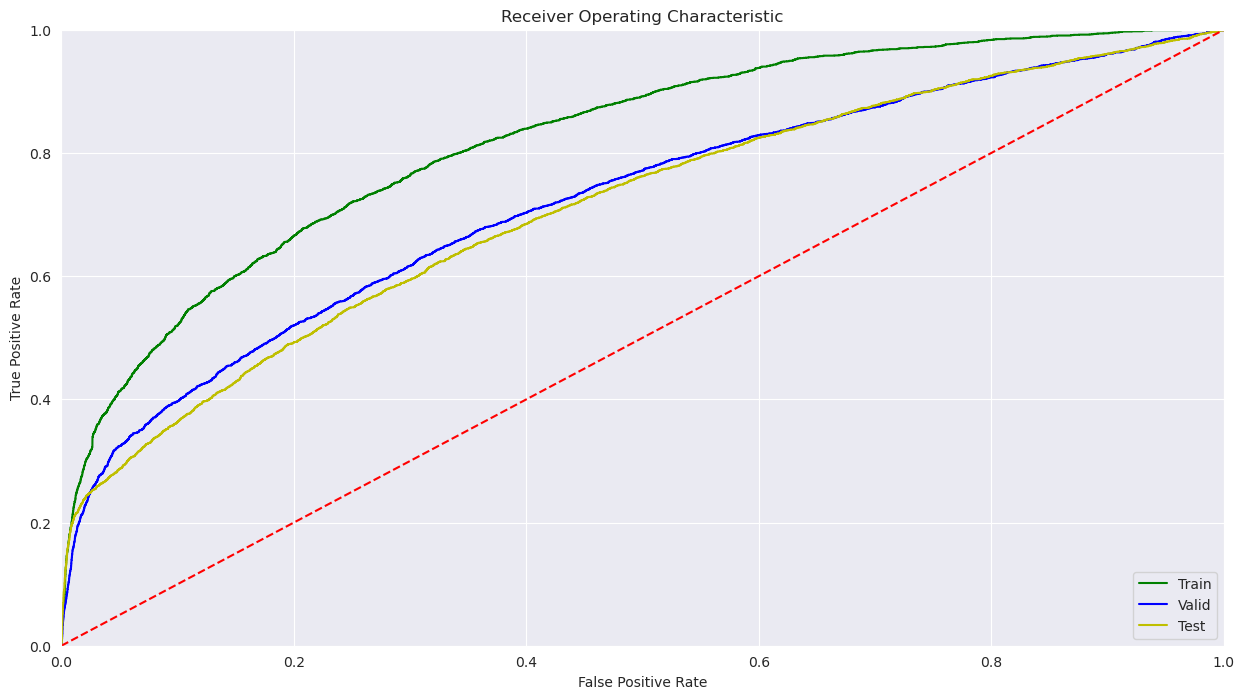

In [101]:
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba_train)
fpr2, tpr2, thresholds2 = roc_curve(y_valid, y_pred_proba_valid)
fpr3, tpr3, thresholds3 = roc_curve(y_test, y_pred_proba_test)
plt.figure(figsize=(15, 8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'g', label=f'Train')
plt.plot(fpr2, tpr2, 'b', label=f'Valid')
plt.plot(fpr3, tpr3, 'y', label=f'Test')
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

##### Снижение производительности модели за счет дисбаланса классов и разделения данных по времени (плохо видит временные паттерны)

### 12. Расчет основных метрик оценки

In [129]:
def calculate_metrics(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1


precision, recall, f1 = calculate_metrics(y_test, y_pred_test)
print('My metrics:')
print(f'Precision: {precision}, Recall: {recall}, F1: {f1}')
print('Sklearn metrics:')
print(
    f'Precision: {precision_score(y_test, y_pred_test)}, Recall: {recall_score(y_test, y_pred_test)}, F1: {f1_score(y_test, y_pred_test)}')

My metrics:
Precision: 0.2262332990750257, Recall: 0.5751143043762247, F1: 0.32472801032638765
Sklearn metrics:
Precision: 0.2262332990750257, Recall: 0.5751143043762247, F1: 0.3247280103263876


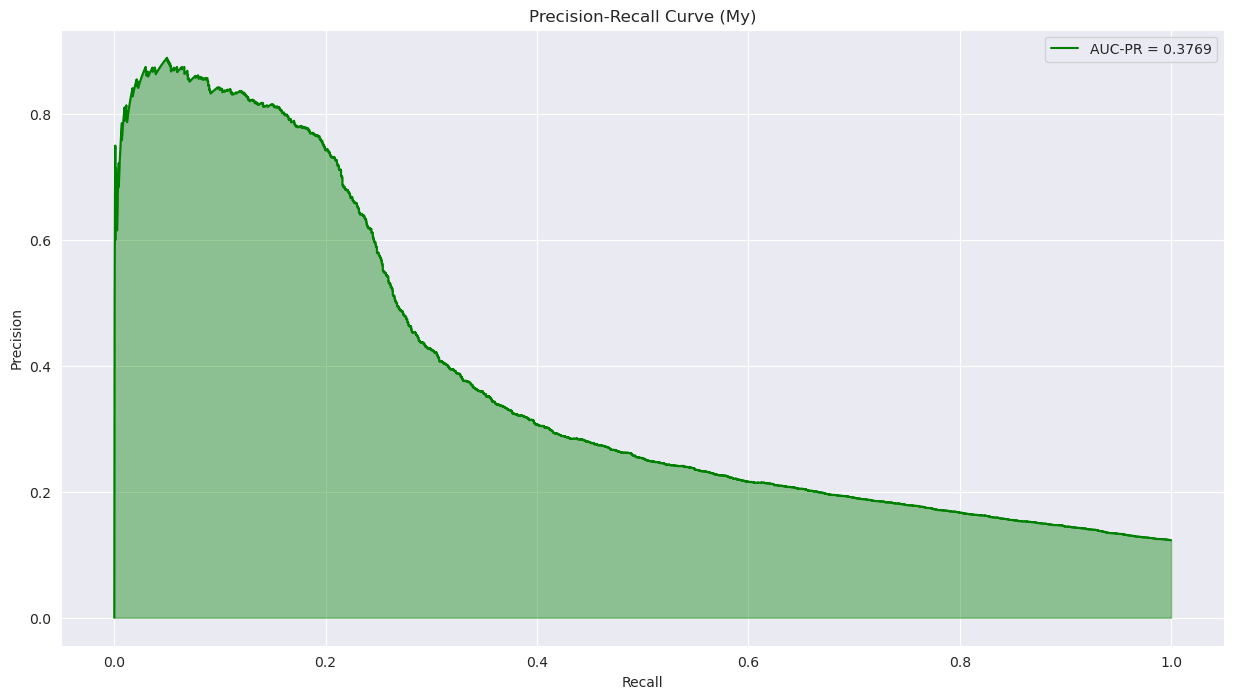

In [128]:
def auc_pr_binary(y_true, y_pred_proba):
    y_true = np.array(y_true)
    y_pred_proba = np.array(y_pred_proba)

    sorted_indices = np.argsort(y_pred_proba)[::-1]  # Сортируем вероятности и метки по убыванию вероятности
    y_true_sorted = y_true[sorted_indices]

    TP = 0  # True Positives
    FP = 0  # False Positives
    FN = np.sum(y_true == 1)  # False Negatives изначально - это все положительные
    precision_list = []
    recall_list = []

    # Для каждого порога вероятности
    for i in range(len(y_true)):
        # Обновляем количество TP, FP и FN
        if y_true_sorted[i] == 1:
            TP += 1
            FN -= 1
        else:
            FP += 1

        # Рассчитываем precision и recall для текущего порога
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0

        # Добавляем в список
        precision_list.append(precision)
        recall_list.append(recall)

    # Вычисление AUC-PR с использованием метода трапеции
    auc_pr_value = np.trapz(precision_list, recall_list)

    return np.array(precision_list), np.array(recall_list), auc_pr_value


precision, recall, auc_pr_value = auc_pr_binary(y_test, y_pred_proba_test)
plt.figure(figsize=(15, 8))
plt.plot(recall, precision, color='g', label=f'AUC-PR = {auc_pr_value:.4f}')
plt.fill_between(recall, precision, color='g', alpha=0.4)
plt.title('Precision-Recall Curve (My)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.show()

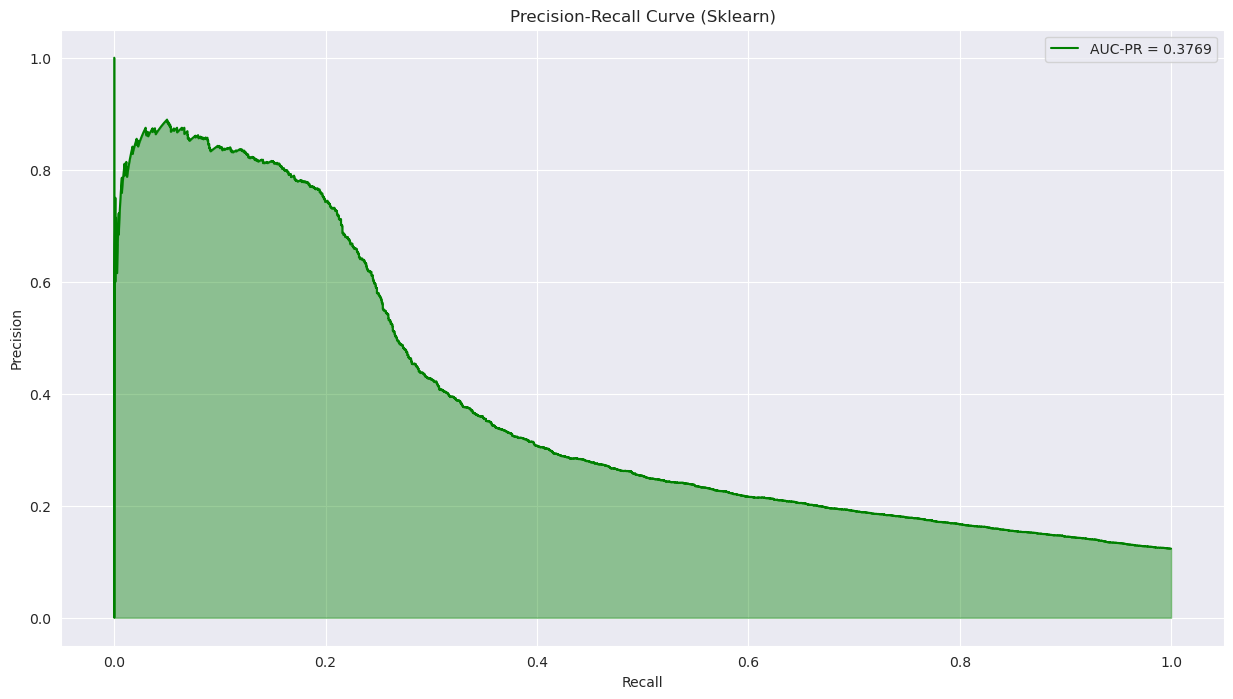

In [127]:
def calculate_auc_rp(y_true, y_pred_proba):
    # Получаем precision, recall и пороги для различных значений вероятности
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)

    # Вычисляем AUC-PR (площадь под PR-кривой)
    auc_pr_value = auc(recall, precision)

    return precision, recall, auc_pr_value


precision, recall, auc_pr_value = calculate_auc_rp(y_test, y_pred_proba_test)
plt.figure(figsize=(15, 8))
plt.plot(recall, precision, color='g', label=f'AUC-PR = {auc_pr_value:.4f}')
plt.fill_between(recall, precision, color='g', alpha=0.4)
plt.title('Precision-Recall Curve (Sklearn)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.show()

### 13. Выбор лучшей метрики оценки
##### Для обнаружения неудачной покупки (IsBadBuy = 1) в условиях сильного дисбаланса классов лучше использовать recall, и повысить вероятность того, что модель правильно идентифицирует все реальные проблемы (неудачные покупки)  